In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import dill
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
import wandb
from nnfabrik.builder import get_data
from focal_frequency_loss import FocalFrequencyLoss as FFL

import csng
from csng.InvertedEncoder import InvertedEncoder
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters, plot_losses
from csng.losses import MultiSSIMLoss, SSIMLoss, CroppedLoss, Loss, MS_SSIMLoss, PerceptualLoss, EncoderPerceptualLoss
from csng.data import MixedBatchLoader
from csng.readins import (
    MultiReadIn,
    HypernetReadIn,
    ConvReadIn,
    AttentionReadIn,
    FCReadIn,
    AutoEncoderReadIn,
    Conv1dReadIn,
)

from BoostedInvertedEncoder import BoostedInvertedEncoder
from encoder import get_encoder
from data_utils import get_mouse_v1_data, PerSampleStoredDataset, append_syn_dataloaders

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

%env "WANDB_NOTEBOOK_NAME" "cnn_decoder.ipynb"
wandb.login()

DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'
env: "WANDB_NOTEBOOK_NAME"="cnn_decoder.ipynb"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnny1188. Use `wandb login --relogin` to force relogin


True

In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    # "device": "cpu",
    "seed": 0,
    # "crop_win": (slice(7, 29), slice(15, 51)),
    "crop_win": (22, 36),
    "wandb": None,
    # "wandb": {
    #     "project": "CSNG",
    #     "group": "sensorium_2022",
    # },
}
print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Data

In [4]:
dataloaders = dict()
config["data"]["mouse_v1"] = None
config["data"]["syn_dataset_config"] = None
config["data"]["data_augmentation"] = None

### Mouse V1 dataset (Sensorium 2022)

In [5]:
### prep data config
filenames = [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
    # "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # mouse 1
    # "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # sensorium+ (mouse 2)
    "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 3)
    # "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 4)
    # "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 5)
    # "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 6)
    # "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip", # pretraining (mouse 7)
]
for f_idx, f_name in enumerate(filenames):
    filenames[f_idx] = os.path.join(DATA_PATH, f_name)

config["data"]["mouse_v1"] = {
    "paths": filenames,
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": filenames,
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        # "batch_size": 16,
        "batch_size": 7,
        "seed": config["seed"],
        "use_cache": False,
    },
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 5,
    "device": config["device"],
}

In [6]:
### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config["data"])

Training dataset:	 4473 samples
Validation dataset:	 525 samples
Test dataset:		 140 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([5, 1, 36, 64])
  min=-1.750  max=2.225
  mean=0.250  std=1.007
responses:
  torch.Size([5, 8372])
  min=0.000  max=10.566
  mean=0.272  std=0.503
neuronal coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593


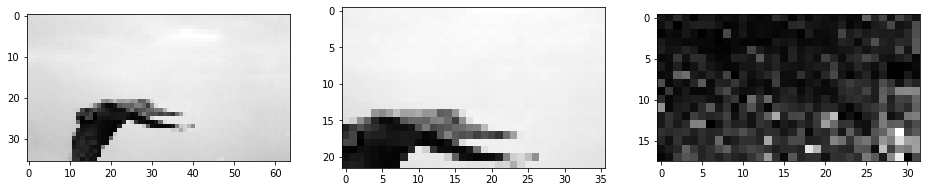

In [7]:
### show data
sample_data_key = dataloaders["mouse_v1"]["test"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["test"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_y_bins):
    for j in range(n_x_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[j] <= coords[:,0]) &\
               (coords[:,0] < x_bins[j + 1]) &\
               (y_bins[i] <= coords[:,1]) &\
               (coords[:,1] < y_bins[i + 1])
        binned_resp[i,j] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

### Synthetic dataset (different image stimuli -> encoder -> responses)

In [ ]:
### append synthetic data
config["data"]["syn_dataset_config"] = {
    "data_keys": [
        # "21067-10-18",
        # "22846-10-16",
        # "23343-5-17",
        # "23656-14-22",
        # "23964-4-22",
    ],
    "batch_size": 3,
    "append_data_parts": ["train"],
    "data_key_prefix": "syn",
}

dataloaders = append_syn_dataloaders(dataloaders, config=config["data"]["syn_dataset_config"])

In [ ]:
### show data
syn_stim, syn_resp, syn_pupil_center = next(iter(dataloaders["mouse_v1"]["train"].dataloaders[-1]))
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {syn_stim.shape}"
    f"\n  min={syn_stim.min().item():.3f}  max={syn_stim.max().item():.3f}"
    f"\n  mean={syn_stim.mean().item():.3f}  std={syn_stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {syn_resp.shape}"
    f"\n  min={syn_resp.min().item():.3f}  max={syn_resp.max().item():.3f}"
    f"\n  mean={syn_resp.mean().item():.3f}  std={syn_resp.std().item():.3f}"
    "\nNeuron coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
    "\nPupil center:"
    f"\n  {syn_pupil_center.shape}"
    f"\n  min={syn_pupil_center.min().item():.3f}  max={syn_pupil_center.max().item():.3f}"
    f"\n  mean={syn_pupil_center.mean().item():.3f}  std={syn_pupil_center.std().item():.3f}"
)

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.imshow(syn_stim[0].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(122)
reshape_to = None
for i in range(30, 150):
    if syn_resp.shape[-1] % i == 0:
        reshape_to = (i, syn_resp.shape[-1] // i)
        break
if reshape_to != None:
    ax.imshow(syn_resp[0].view(reshape_to).squeeze(0).unsqueeze(-1).cpu(), cmap="gray")

plt.show()

## Encoder

In [8]:
encoder = get_encoder(device=config["device"], eval_mode=True)

Loading encoder checkpoint from /media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/encoder_sens22.pth


In [ ]:
### load encoder
print("Loading encoder...")

from lurz2020.models.models import se2d_fullgaussian2d

### load pretrained encoder ckpt
encoder_ckpt = torch.load(
    os.path.join(DATA_PATH, "models", "encoder.pt"),
    map_location=config["device"],
    pickle_module=dill,
)

### get temporary dataloaders for the encoder
_dataloaders = get_data(
    encoder_ckpt["config"]["data"]["dataset_fn"],
    encoder_ckpt["config"]["data"]["dataset_config"]
)

### init encoder
encoder = se2d_fullgaussian2d(
    **encoder_ckpt["config"]["encoder"]["model_config"],
    dataloaders=_dataloaders,
    seed=encoder_ckpt["config"]["seed"],
).float()
encoder.load_state_dict(encoder_ckpt["encoder_state"], strict=True)
encoder.to(config["device"])
encoder.eval()
del _dataloaders

## Compare decoders

In [39]:
def eval_decoder(model, dataloader, loss_fns, normalize_decoded, config):
    model.eval()
    val_losses = {loss_fn_name: {"total": 0} for loss_fn_name in loss_fns.keys()}
    i = 0
    denom_data_keys = {}

    for b in dataloader:
        ### combine from all data keys
        for data_key, stim, resp, neuron_coords, pupil_center in b:
            if model.__class__.__name__ == "InvertedEncoder":
                stim_pred, _, _ = model(
                    resp_target=resp,
                    stim_target=stim,
                    additional_encoder_inp={
                        "data_key": data_key,
                        "pupil_center": pupil_center,
                    }
                )
            elif hasattr(model, "core") and model.core.__class__.__name__ == "L2O_Decoder":
                raise NotImplementedError("L2O_Decoder not implemented yet - data needs to be standardized")
                stim_pred, _ = model(
                    x=resp,
                    data_key=data_key,
                    neuron_coords=neuron_coords,
                    pupil_center=pupil_center,
                    additional_core_inp=dict(
                        train=False,
                        stim=None,
                        resp=resp,
                        neuron_coords=neuron_coords,
                        pupil_center=pupil_center,
                        data_key=data_key,
                        n_steps=config["decoder"]["n_steps"],
                        x_hat_history_iters=None,
                    ),
                )
            elif isinstance(model, BoostedInvertedEncoder):
                stim_pred, _, _ = model(
                    resp,
                    train=False,
                    data_key=data_key,
                    neuron_coords=neuron_coords,
                    pupil_center=pupil_center,
                )
            else:
                stim_pred = model(
                    resp,
                    data_key=data_key,
                    neuron_coords=neuron_coords,
                    pupil_center=pupil_center,
                )

            if normalize_decoded:
                stim_pred = normalize(stim_pred)

            for loss_fn_name, loss_fn in loss_fns.items():
                loss = loss_fn(stim_pred, stim, data_key=data_key, phase="val").item()
                val_losses[loss_fn_name]["total"] += loss
                val_losses[loss_fn_name][data_key] = loss if data_key not in val_losses[loss_fn_name] else val_losses[loss_fn_name][data_key] + loss
            
            i += stim.shape[0]
            denom_data_keys[data_key] = denom_data_keys[data_key] + stim.shape[0] if data_key in denom_data_keys else stim.shape[0]

    for loss_name in val_losses:
        val_losses[loss_name]["total"] /= i
        for k in denom_data_keys:
            val_losses[loss_name][k] /= denom_data_keys[k]

    return val_losses

In [9]:
def get_all_data(config):
    dls, neuron_coords = get_mouse_v1_data(config=config["data"])
    if "syn_dataset_config" in config["data"] and config["data"]["syn_dataset_config"] is not None:
        dls = append_syn_dataloaders(dls, config=config["data"]["syn_dataset_config"]) # append synthetic data
    if "data_augmentation" in config["data"] and config["data"]["data_augmentation"] is not None:
        dls = append_data_aug_dataloaders(
            dataloaders=dls,
            config=config["data"]["data_augmentation"],
        )
    return dls, neuron_coords

In [32]:
### config for collecting results (1)
runs_to_compare = {}

In [33]:
### config for collecting results (2)
runs_to_compare["Inverted Encoder"] = torch.load("encoder_inversion_eval_all_mice.pt", pickle_module=dill)["Inverted Encoder"]
# runs_to_compare["Inverted Encoder"] = {
#     "decoder": InvertedEncoder(
#         encoder=encoder,
#         img_dims=stim.shape[1:],
#         stim_pred_init="zeros",
#         opter_cls=torch.optim.SGD,
#         opter_config={"lr": 1500, "momentum": 0},
#         n_steps=400,
#         resp_loss_fn=F.mse_loss,
#         stim_loss_fn=SSIMLoss(
#             window=config["crop_win"],
#             log_loss=True,
#             inp_normalized=True,
#             inp_standardized=False,
#         ),
#         img_gauss_blur_config=None,
#         img_grad_gauss_blur_config={"kernel_size": 17, "sigma": 2},
#         device=config["device"],
#     ).to(config["device"]),
#     "run_name": None
# }

# ### FCReadIn
# "FCReadIn": {
#     "run_name": "2024-02-25_17-09-59",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-25_17-09-59", "decoder.pt"),
# },
# "FCReadIn - Autoencoding": {
#     "run_name": "2024-02-27_00-27-17",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-27_00-27-17", "decoder.pt"),
# },
# "FCReadIn - Contrastive reg.": {
#     "run_name": "2024-02-28_21-27-46",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_21-27-46", "decoder.pt"),
# },

# ### ConvReadIn
# "ConvReadIn": {
#     "run_name": "2024-02-25_21-16-59",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-25_21-16-59", "decoder.pt"),
# },
# # "ConvReadIn - no shift": {
# "ConvReadIn - no pupil center training": {
#     "run_name": "2024-03-06_12-46-53",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-06_12-46-53", "decoder.pt"),
# },
# "ConvReadIn - Autoencoding": {
#     "run_name": "2024-02-27_13-01-15",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-27_13-01-15", "decoder.pt"),
# },
# "ConvReadIn - Contrastive reg.": {
#     "run_name": "2024-02-27_00-04-30",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-27_00-04-30", "decoder.pt"),
# },
# "ConvReadIn - Fine-tuned": {
#     "run_name": "2024-02-28_00-55-12",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_00-55-12", "decoder.pt"),
# },
# "ConvReadIn - From scratch": { # comparison to the above
#     "run_name": "2024-02-28_00-59-51",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_00-59-51", "decoder.pt"),
# },
# runs_to_compare["ConvReadIn - Con. reg."] = {
#     "run_name": "2024-03-02_12-28-42",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-02_12-28-42", "decoder.pt"),
# }
runs_to_compare["ConvReadIn - Con. reg., no shifter"] = {
    "run_name": "2024-03-13_16-14-37",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-13_16-14-37", "decoder.pt"),
}
# runs_to_compare["ConvReadIn - Con. reg. + Fine-tuned"] = {
#         "run_name": "2024-02-28_13-08-22",
#         "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_13-08-22", "decoder.pt"),
#     }
# runs_to_compare["ConvReadIn - Con. reg. (large) with neuron embeddings"] = {
#     "run_name": "2024-03-03_00-59-02",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-03_00-59-02", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn - Con. reg. + Data aug."] = {
#     "run_name": "2024-03-08_13-08-36",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-08_13-08-36", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn - Synth. data 43%"] = {
#     "run_name": "2024-03-11_01-05-34",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-11_01-05-34", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn - Synth. data 30% + Data aug."] = {
#     "run_name": "2024-03-11_20-03-03",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-11_20-03-03", "decoder.pt"),
# }


### Single datasets
# runs_to_compare["ConvReadIn (mouse #1) - Fine-tuned"] = {
#     "run_name": "2024-02-28_13-09-19",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_13-09-19", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn (mouse #1) - From scratch"] = {
#     "run_name": "2024-02-28_15-10-47",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_15-10-47", "decoder.pt"),
# }
# "ConvReadIn (mouse #1) - With neuron embeddings": {
#     "run_name": "2024-03-03_19-47-31",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-03_19-47-31", "decoder.pt"),
# },
# runs_to_compare["ConvReadIn (mouse #1) - From scratch + Synth. data 50%"] = {
#     "run_name": "2024-03-10_21-32-52",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-10_21-32-52", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn (mouse #1) - From scratch + Synth. data 40% + Data aug."] = {
#     "run_name": "2024-03-12_18-52-18",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-12_18-52-18", "decoder.pt"),
# }
runs_to_compare["ConvReadIn (mouse #1) - From scratch, SSIM"] = {
    "run_name": "2024-03-16_17-13-54",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-16_17-13-54", "decoder.pt"),
}
# runs_to_compare["ConvReadIn (mouse #1) - From scratch, SSIM, no z-coord"] = {
#     "run_name": "2024-03-17_11-16-25",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-17_11-16-25", "decoder.pt"),
# }
runs_to_compare["ConvReadIn (mouse #1) - From scratch, MultiSSIM"] = {
    "run_name": "2024-03-16_21-01-52",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-16_21-01-52", "decoder.pt"),
}
# "Boosted Inverted Encoder (mouse #1)": {
#     "run_name": "2024-03-06_01-15-13",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "boosted_inverted_encoder", "2024-03-06_01-15-13", "decoder.pt"),
# },
# "Boosted Inverted Encoder (mouse #1)": {
#     "run_name": "2024-03-07_01-01-23",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "boosted_inverted_encoder", "2024-03-07_01-01-23", "decoder.pt"),
# },


# "ConvReadIn (mouse #2) - Fine-tuned": {
#     "run_name": "2024-02-28_17-20-42",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_17-20-42", "decoder.pt"),
# },
# "ConvReadIn (mouse #2) - From scratch": {
#     "run_name": "2024-02-28_19-46-10",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_19-46-10", "decoder.pt"),
# },

# "ConvReadIn (mouse #3) - Fine-tuned": {
#     "run_name": "2024-02-29_00-57-59",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-29_00-57-59", "decoder.pt"),
# },
# "ConvReadIn (mouse #3) - From scratch": {
#     "run_name": "2024-02-29_10-35-56",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-29_10-35-56", "decoder.pt"),
# },

loss_fns = {
    "Log SSIM Loss": SSIMLoss(
        window=config["crop_win"],
        log_loss=True,
        inp_normalized=True,
        inp_standardized=False,
        reduction="sum",
    ),
    "Log MultiSSIM Loss": MultiSSIMLoss(
        window=config["crop_win"],
        log_loss=True,
        inp_normalized=True,
        inp_standardized=False,
        reduction="sum",
    ),
    "SSIM Loss": SSIMLoss(
        window=config["crop_win"],
        log_loss=False,
        inp_normalized=True,
        inp_standardized=False,
        reduction="sum",
    ),
    "MultiSSIM Loss": MultiSSIMLoss(
        window=config["crop_win"],
        log_loss=False,
        inp_normalized=True,
        inp_standardized=False,
        reduction="sum",
    ),
    # "Perceptual Loss": PerceptualLoss(
    #     window=config["crop_win"],
    #     inp_standardized=False,
    #     resize=True,
    # ),
    "Perceptual Loss": CroppedLoss(
        window=config["crop_win"],
        normalize=True,
        standardize=False,
        loss_fn=EncoderPerceptualLoss(
            encoder=encoder,
            device=config["device"],
        ),
    ),
    "FFL": CroppedLoss(
        window=config["crop_win"],
        normalize=False,
        standardize=True,
        loss_fn=FFL(loss_weight=1, alpha=1.0),
    ),
    "MSE Loss": lambda x_hat, x: F.mse_loss(
        standardize(crop(x_hat, config["crop_win"])),
        standardize(crop(x, config["crop_win"])),
        reduction="none",
    ).mean((1,2,3)).sum(),
    "MAE Loss": lambda x_hat, x: F.l1_loss(
        standardize(crop(x_hat, config["crop_win"])),
        standardize(crop(x, config["crop_win"])),
        reduction="none",
    ).mean((1,2,3)).sum(),
}
for k in loss_fns.keys():
    loss_fns[k] = Loss(
        model=None,
        config={
            "loss_fn": loss_fns[k],
            "l1_reg_mul": 0,
            "l2_reg_mul": 0,
            "con_reg_mul": 0,
        }
    )

eval_all_ckpts = False
show_reconstructions = False

In [38]:
### load models
for k in runs_to_compare.keys():
    if "test_losses" in runs_to_compare[k]:
        continue
    run_dict = runs_to_compare[k]
    run_name = run_dict["run_name"]

    ckpt_paths = []
    if "decoder" in run_dict and run_dict["decoder"] is not None:
        ckpt_paths.append(None)
    else:
        if eval_all_ckpts:
            ckpts_dir = os.path.join(os.path.dirname(run_dict["ckpt_path"]), "ckpt")
            ckpt_paths.extend([os.path.join(os.path.dirname(run_dict["ckpt_path"]), "ckpt", ckpt_name) for ckpt_name in os.listdir(ckpts_dir)])
        else:
            ckpt_paths.append(run_dict["ckpt_path"])

    ### eval all ckpts
    all_test_losses, all_configs, all_histories, all_best_val_losses = [], [], [], []
    for ckpt_path in ckpt_paths:
        if "decoder" in run_dict and run_dict["decoder"] is not None:
            print(f"Using {k} model from run_dict...")
            decoder = run_dict["decoder"]
            ckpt = None
            # decoder.encoder.shifter = None
        elif "boosted_inverted_encoder" in ckpt_path:
            ### load ckpt and init
            ckpt = torch.load(ckpt_path, map_location=config["device"], pickle_module=dill)
            ckpt_config = ckpt["config"]
            decoder = BoostedInvertedEncoder(**ckpt_config["decoder"]["model"]).to(config["device"])
            decoder.load_state_dict(ckpt["best"]["model"], strict=True)
            decoder.eval()
        else:
            print(f"Loading {k} model from ckpt (run name: {run_name})...")
            ### load ckpt and init
            ckpt = torch.load(ckpt_path, map_location=config["device"], pickle_module=dill)
            ckpt_config = ckpt["config"]
            decoder = MultiReadIn(**ckpt_config["decoder"]["model"]).to(config["device"])
            if eval_all_ckpts:
                decoder.load_state_dict(ckpt["decoder"])
            else:
                decoder.load_state_dict(ckpt["best"]["model"])
            decoder.eval()
            # for r_k in decoder.readins:
            #     decoder.readins[r_k][0].shift_coords = False
        
        if show_reconstructions:
            ### show reconstructions
            if decoder.__class__.__name__ == "InvertedEncoder":
                stim_pred_best, _, _ = decoder(
                    resp.to(config["device"]),
                    stim.to(config["device"]),
                    additional_encoder_inp={
                        "data_key": sample_data_key,
                        "pupil_center": pupil_center.to(config["device"]),
                    }
                )
                stim_pred_best = stim_pred_best.detach().cpu()
            else:
                stim_pred_best = decoder(
                    resp.to(config["device"]),
                    data_key=sample_data_key,
                    neuron_coords=neuron_coords[sample_data_key],
                    pupil_center=pupil_center.to(config["device"]),
                ).detach().cpu()
            fig = plot_comparison(
                target=crop(stim[:8], config["crop_win"]).cpu(),
                pred=crop(stim_pred_best[:8], config["crop_win"]).cpu(),
            )

        ### eval
        dls, neuron_coords = get_all_data(config=config)
        test_losses = eval_decoder(
            model=decoder,
            dataloader=dls["mouse_v1"]["test"],
            loss_fns=loss_fns,
            # normalize_decoded=True if "l2o" in k.lower() else False,
            normalize_decoded=False,
            config=config,
        )

        all_test_losses.append(test_losses)
        all_configs.append(ckpt_config if ckpt is not None else None)
        all_histories.append(ckpt["history"] if ckpt is not None else None)
        all_best_val_losses.append(ckpt["best"]["val_loss"] if ckpt is not None else None)

    ### save
    runs_to_compare[k]["test_losses"] = all_test_losses
    runs_to_compare[k]["config"] = all_configs
    runs_to_compare[k]["history"] = all_histories
    runs_to_compare[k]["best_val_loss"] = all_best_val_losses
    runs_to_compare[k]["ckpt_paths"] = ckpt_paths

Loading ConvReadIn (mouse #1) - From scratch, SSIM, no z-coord model from ckpt (run name: 2024-03-17_11-16-25)...
[WARNING] resp_shape in core_config will be overwritten by the output of the last readin layer (shape 144)


In [ ]:
### save all_test_losses
# torch.save(runs_to_compare, "16-03-24__encoder_inversion_eval_all_mice.pt", pickle_module=dill)
# runs_to_compare = torch.load("encoder_inversion_eval_all_mice.pt", pickle_module=dill)

In [ ]:
### plot losses together

### config
to_plot = "val_loss"
conv_win = 10
ckpt_idx = 0

### plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

for k, run_dict in runs_to_compare.items():
    if run_dict["history"][ckpt_idx] is None or to_plot not in run_dict["history"][ckpt_idx]:
        print(f"Skipping {k}...")
        continue
    if conv_win is not None and (run_dict["history"][ckpt_idx] is not None and np.nan not in run_dict["history"][ckpt_idx]):
        vals_to_plot = np.convolve(run_dict["history"][ckpt_idx][to_plot], np.ones(conv_win) / conv_win, mode="valid")
    else:
        vals_to_plot = run_dict["history"][ckpt_idx][to_plot]
    ax.plot(
        [t for t in range(len(vals_to_plot)) if vals_to_plot[t] is not np.nan],
        [v for v in vals_to_plot if v is not np.nan],
        label=k,
        linewidth=3,
    )

if to_plot == "train_loss":
    ax.set_title("Training log SSIM loss", fontsize=16, pad=20)
elif to_plot == "val_loss":
    ax.set_title("Validation log SSIM loss", fontsize=16, pad=20)
else:
    raise ValueError(f"Unknown loss type: {to_plot}")

ax.set_xlabel("Epoch", fontsize=15, labelpad=20)
ax.set_ylabel("Log SSIM loss", fontsize=15, labelpad=20)
# ax.set_ylim(1.25, None)
# ax.set_ylim(1.3, 1.75)
# ax.set_xlim(0, 80)
ax.legend(
    loc="upper right",
    # loc="upper center",
    # loc="lower left",
    # loc="lower center",
    fontsize=14,
    frameon=False,
    # bbox_to_anchor=(1.16, 1),
    bbox_transform=ax.transAxes,
    # title="",
    title_fontsize=15,
    ncol=1,
)
# increase width of legend lines
leg = ax.get_legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)


# set larger font for x and y ticks
ax.tick_params(axis="both", which="major", labelsize=14)

# remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

In [40]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height.
    https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.3f}",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 10),  # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=14,
            rotation=90,
        )

In [41]:
runs_to_compare["Inverted Encoder"]["test_losses"][0]["FFL"] = runs_to_compare["Inverted Encoder"]["test_losses"][0]["FFE"]

/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-03-17_11-16-25/decoder.pt


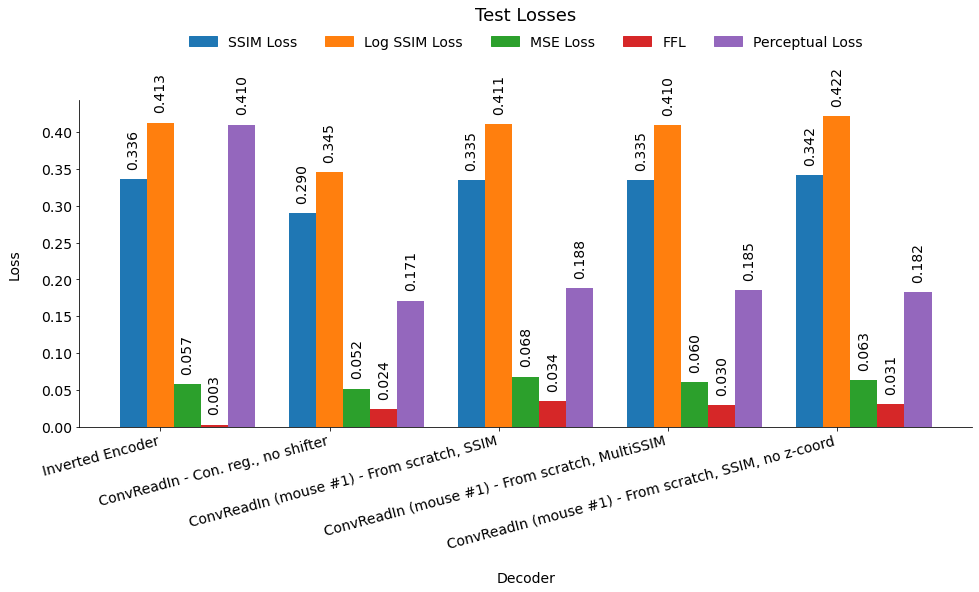

In [43]:
for run_idx in range(len(runs_to_compare[k]["test_losses"])):
    ### bar plot of test losses
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(111)
    print(run_dict["ckpt_paths"][run_idx])

    ### grouped bar plot (run_dict["test_losses"] is a dict containing multiple losses)
    bar_width = 0.8
    losses_to_plot = [
        "SSIM Loss",
        "Log SSIM Loss",
        # "Log MultiSSIM Loss",
        # "Log SSIM Loss (win_size=5)",
        # "Log SSIM Loss (win_size=7)",
        "MSE Loss",
        # "MAE Loss",
        "FFL",
        "Perceptual Loss",
    ]
    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
    ]

    for i, (k, run_dict) in enumerate(runs_to_compare.items()):
        for j, loss in enumerate(losses_to_plot):
            rects = ax.bar(
                i - bar_width / len(losses_to_plot) + j * bar_width / len(losses_to_plot),
                run_dict["test_losses"][run_idx][loss]["total"],
                width=bar_width / len(losses_to_plot),
                color=colors[j],
            )
            autolabel(rects)

    ### add legend with color explanation
    from matplotlib import patches as mpatches
    ax.legend(
        handles=[
            mpatches.Patch(color=colors[i], label=loss)
            for i, loss in enumerate(losses_to_plot)
        ],
        loc="upper center",
        bbox_to_anchor=(0.5, 1.24),
        ncol=len(losses_to_plot),
        fontsize=14,
        frameon=False,
    )

    ax.set_title(
        "Test Losses",
        fontsize=18,
        pad=80,
    )
    ax.set_xticks(range(len(runs_to_compare)))
    ax.set_xticklabels(runs_to_compare.keys())
    ### with rotatation of the xtick labels
    ax.set_xticklabels(
        [k for k in runs_to_compare.keys()],
        rotation=15,
        ha="right",
    )
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.set_xlabel("Decoder", fontsize=14, labelpad=20)
    ax.set_ylabel("Loss", fontsize=14, labelpad=20)
    ax.set_ylim(0, None)

    # remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.show()